In [1]:
import copy
import pywt
import h5py
import scipy.stats
import scipy.signal
import scipy.io

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

from kpnet.handler import *
from kpnet.network import *
from kpnet.signal import *
from kpnet.callback import *
from kpnet.entropy import *
from kpnet.patterns import *
from kpnet.utils import *

from wavelets import *

In [24]:
N = 64
time_interval = 2 ** 16
chunk = 2 ** 13

In [3]:
np.random.seed(0)
#neuron = 5
# 20, 0.078
# Period - N, 3, alpha=0.044, beta=0.2, gamma=3.2
net = KPNetworkTanh(N, alpha=0.05, beta=0.3, gamma=2.2)

callbacks = {}
callbacks['W'] = WeightsCallback(time_interval, N, chunk, 'data/data.hfd5')
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(N), ZeroSignal(N)])
handler = ComputationHandler(time_interval)
results = handler.run(net, signal, callbacks)

In [2]:
W = h5py.File('data/data.hfd5', 'r')['W']

In [86]:
class SWTDistribution:
    def __init__(self, signal, wavelet):
        self.level = pywt.swt_max_level(signal.shape[0])
        self.swt   = np.asarray([D ** 2  for _, D in pywt.swt(signal, wavelet, level=self.level)])
        self.value = np.flip(np.sum(self.swt, axis=1) / np.sum(self.swt), axis=-1)
    
    @property
    def entropy(self):
        return scipy.stats.entropy(self.value)
    
    @property
    def moda(self):
        return np.argmax(self.value)
    
    def divergence(self, other):
        return scipy.stats.entropy(self.value, other.value)
    
    def jensen(self, other):
        return .5 * (self.divergence(other) + other.divergence(self))


class DWTDistribution:
    def __init__(self, signal, wavelet):
        level = pywt.dwt_max_level(signal.shape[0], pywt.Wavelet(wavelet).dec_len)
        dwt = pywt.wavedec(signal, wavelet, level=level)
        self.value = np.flip(np.asarray([np.sum(coeffs ** 2) for coeffs in dwt]), axis=-1)
        self.value /= np.sum(self.value)
    
    @property
    def entropy(self):
        return scipy.stats.entropy(self.value)
    
    @property
    def moda(self):
        return np.argmax(self.value)
    
    def divergence(self, other):
        return scipy.stats.entropy(self.value, other.value)
    
    def jensen(self, other):
        return .5 * (self.divergence(other) + other.divergence(self))


class CWTDistribution:
    def __init__(self, signal, wavelet):
        # self.power = WaveletTransform(signal, wavelet=wavelet, mask_coi=True).wavelet_power
        wa = WaveletTransform(signal, wavelet=wavelet)
        coi = wa.wavelet.coi
        s = wa.scales
        t = wa.time
        T, S = np.meshgrid(t, s)
        inside_coi = (coi(S) < T) & (T < (T.max() - coi(S)))
        masked_power = np.ma.masked_where(~inside_coi, wa.wavelet_power)
        masked_power.set_fill_value(0)
        self.value = np.sum(masked_power.filled(), axis=1) / np.sum(masked_power.filled()) 
    
    @property
    def entropy(self):
        return scipy.stats.entropy(self.value)
    
    @property
    def moda(self):
        return np.argmax(self.value)
    
    def divergence(self, other):
        return scipy.stats.entropy(self.value, other.value)
    
    def jensen(self, other):
        return .5 * (self.divergence(other) + other.divergence(self))

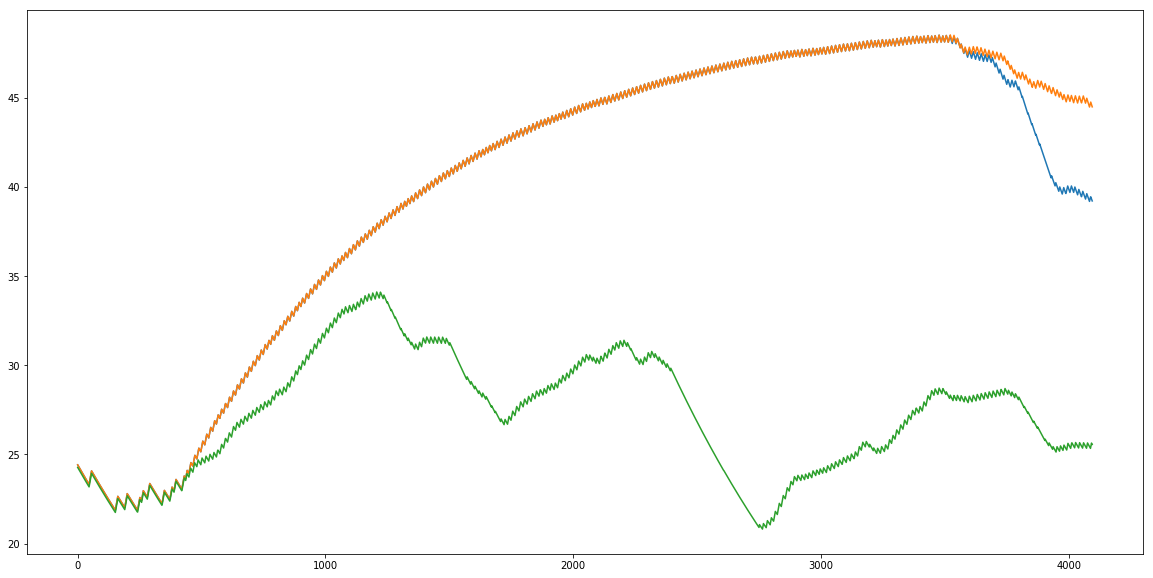

In [87]:
signal1 = W[5, 13, 6000:10096]
signal2 = W[5, 11, 6000:10096]
signal3 = W[5, 14, 6000:10096]

plt.figure(figsize=(20, 10))
plt.plot(signal1)
plt.plot(signal2)
plt.plot(signal3)
plt.show()

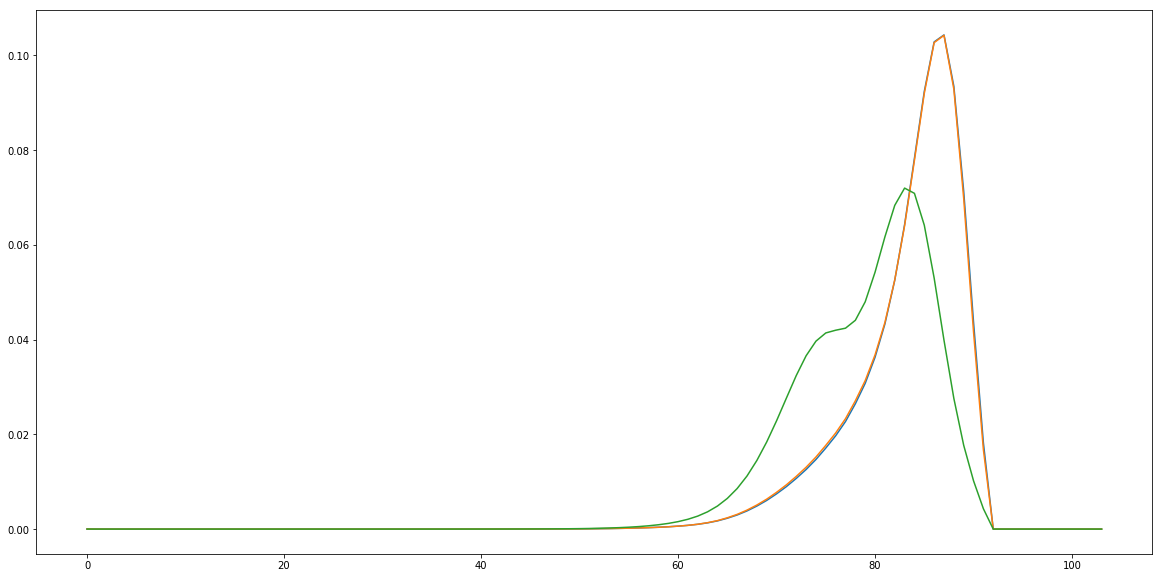

0.000245578492077
0.291538266453
2.94376159555
3.20144213952
87
87
83


In [88]:
dist1 = CWTDistribution(signal1, Ricker()) 
dist2 = CWTDistribution(signal2, Ricker())
dist3 = CWTDistribution(signal3, Ricker())

plt.figure(figsize=(20, 10))
plt.plot(dist1.value)
plt.plot(dist2.value)
plt.plot(dist3.value)
plt.show()

print(dist1.jensen(dist2))
print(dist1.jensen(dist3))
print(dist1.entropy)
print(dist3.entropy)

print(dist1.moda)
print(dist2.moda)
print(dist3.moda)

In [64]:
def connected(dist1, dist2, threshold_ent, threshold_moda):
    ent_cond = dist1.jensen(dist2) <= threshold_ent 
    moda_cond = dist1.moda == dist2.moda
    dist_cond = np.abs(dist1.value[dist1.moda] - dist2.value[dist2.moda]) <= threshold_moda
    return ent_cond and moda_cond and dist_cond

def neuron_cluster(pattern, threshold_ent, threshold_moda):
    visited = [False] * N;
    clusters = []
    pdist = CWTDistribution(pattern, Ricker())
    for i in range(N):
        if not visited[i]:
            cluster = []
            for j in range(N):
                if not visited[j] and j != i:
                    jdist = CWTDistribution(W[i, j, 6000 : 10096], Ricker())
                    if connected(jdist, pdist, threshold_ent, threshold_moda):
                        visited[j] = True
                        cluster.append(j)

            if len(cluster) > 0:
                clusters.append(cluster + [i])
                visited[i] = True
                
    return clusters
                    

In [105]:
class WTDistribution(object):
    def __init__(self):
        self.value = None

    @property
    def entropy(self):
        return scipy.stats.entropy(self.value)
    
    @property
    def moda(self):
        return np.argmax(self.value)
    
    def divergence(self, other):
        return scipy.stats.entropy(self.value, other.value)
    
    def jensen(self, other):
        return .5 * (self.divergence(other) + other.divergence(self))


class DWTDistribution(WTDistribution):
    def __init__(self, signal, wavelet):
        super(DWTDistribution, self).__init__()
        level = pywt.dwt_max_level(signal.shape[0], pywt.Wavelet(wavelet).dec_len)
        dwt = pywt.wavedec(signal, wavelet, level=level)
        self.value = np.flip(np.asarray([np.sum(coeffs ** 2) for coeffs in dwt]), axis=-1)
        self.value /= np.sum(self.value)


class SWTDistribution(WTDistribution):
    def __init__(self, signal, wavelet):
        super(SWTDistribution, self).__init__()
        self.level = pywt.swt_max_level(signal.shape[0])
        self.swt   = np.asarray([D ** 2  for _, D in pywt.swt(signal, wavelet, level=self.level)])
        self.value = np.flip(np.sum(self.swt, axis=1) / np.sum(self.swt), axis=-1)


class CWTDistribution(WTDistribution):
    # todo: optimize coi mapping
    def __init__(self, signal, wavelet):
        super(CWTDistribution, self).__init__()
        wa = WaveletTransform(signal, wavelet=wavelet)
        coi = wa.wavelet.coi
        s = wa.scales
        t = wa.time
        T, S = np.meshgrid(t, s)
        inside_coi = (coi(S) < T) & (T < (T.max() - coi(S)))
        masked_power = np.ma.masked_where(~inside_coi, wa.wavelet_power)
        masked_power.set_fill_value(0)
        self.value = np.sum(masked_power.filled(), axis=1) / np.sum(masked_power.filled()) 


class WTClustering:
    def __init__(self, W, pattern, distclass, wavelet):
        self.W              = W
        self.N              = self.W.shape[0]

        self.pattern        = pattern
        self.distclass      = distclass
        self.wavelet        = wavelet

        self.pdist          = self.distclass(pattern, self.wavelet)

        self.clusters       = []

        self.adj_matrix     = np.zeros(shape=(self.N, self.N))

    @staticmethod
    def connected(dist1, dist2, epsilon, delta):
        ent_cond = dist1.jensen(dist2) <= epsilon 
        moda_cond = dist1.moda == dist2.moda
        dist_cond = np.abs(dist1.value[dist1.moda] - dist2.value[dist2.moda]) <= delta
        return ent_cond and moda_cond and dist_cond

    def run(self, begin, end, epsilon, delta):
        self.clusters = []
        visited = [False] * self.N
        for i in range(self.N):
            if not visited[i]:
                cluster = []
                for j in range(self.N):
                    if not visited[j] and j != i:
                        jdist = self.distclass(self.W[i, j, begin : end], self.wavelet)
                        if self.connected(jdist, self.pdist, epsilon, delta):
                            self.adj_matrix[i, j] = 1
                            self.adj_matrix[j, i] = 1
                            visited[j] = True
                            cluster.append(j)

                if len(cluster) > 0:
                    self.clusters.append(cluster + [i])
                    visited[i] = True
                    
        return self.clusters


    def plot(self, figsize):
        node_colors = [0.5] * self.N
        color_shift = 0.2
        for cluster in self.clusters:
            for elem in cluster:
                node_colors[elem] = color_shift
            color_shift += 0.2
        
        G = nx.from_numpy_matrix(self.adj_matrix)        
        plt.figure(figsize=figsize)
        pos = nx.kamada_kawai_layout(G)
        nx.draw_networkx_nodes(G, pos, node_color = node_colors, alpha = 0.7, node_size = 500)
        nx.draw_networkx_labels(G, pos, {i: str(i) for i in range(N)})
        nx.draw_networkx_edges(G, pos, edge_color='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()

In [106]:
pattern = W[25, 23, 6000:10096]

In [107]:
wtc = WTClustering(W, pattern, CWTDistribution, Ricker())
%time clusters = wtc.run(6000, 10096, 0.003, 0.005)

CPU times: user 5min 55s, sys: 1.05 s, total: 5min 56s
Wall time: 5min 56s


In [108]:
clusters

[[3, 5, 11, 13, 29, 31, 34, 36, 42, 0], [12, 58, 8], [25, 23]]

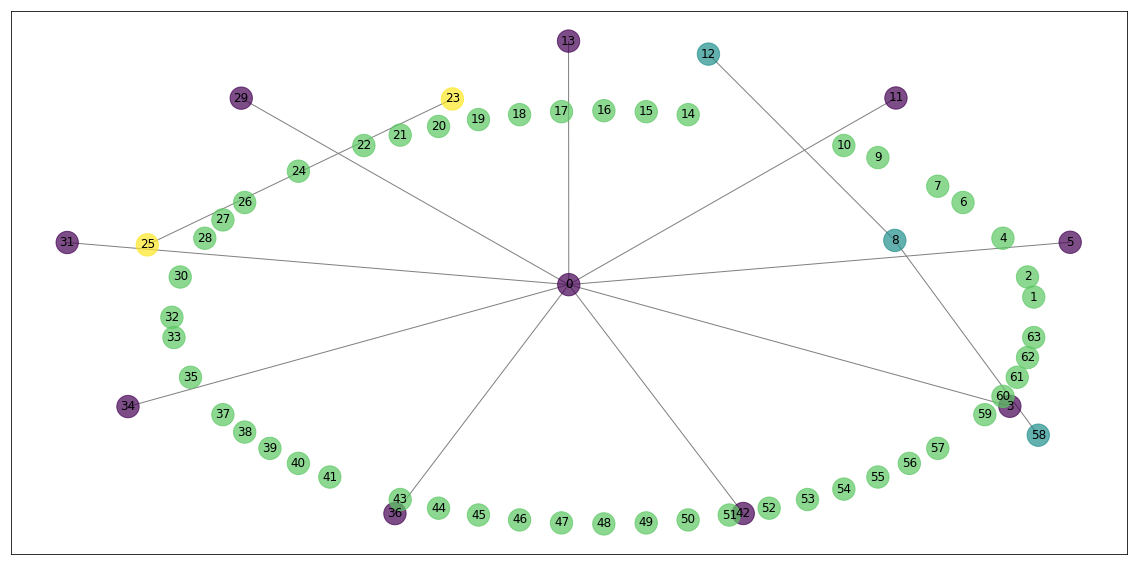

In [110]:
wtc.plot((20, 10))

In [66]:
%time clusters = neuron_cluster(W[25, 23, 6000:10096], 0.003, 0.005)

CPU times: user 7min 4s, sys: 1.29 s, total: 7min 5s
Wall time: 7min 6s


In [68]:
clusters

[[3, 5, 11, 13, 29, 31, 34, 36, 42, 0], [12, 58, 8], [25, 23]]

In [26]:
clusters

[[3, 5, 11, 13, 29, 31, 34, 36, 42, 0], [60, 4], [12, 58, 8], [25, 23]]

In [27]:
def cluster_adjmatrix(clusters):
    adj_matrix = np.zeros(shape=(N, N))
    for cluster in clusters:
        for elem1 in cluster:
            for elem2 in cluster:
                if elem1 != elem2:
                    adj_matrix[elem1, elem2] = 1
    return adj_matrix

In [28]:
def draw_clustered_network(clusters):
    node_colors = [0.5] * N
    color_shift = 0.2
    for cluster in clusters:
        for elem in cluster:
            node_colors[elem] = color_shift
        color_shift += 0.2
    
    g = nx.from_numpy_matrix(cluster_adjmatrix(clusters))        
    plt.figure(figsize=(20, 10))
    pos = nx.kamada_kawai_layout(g)
    nx.draw_networkx_nodes(g, pos, node_color = node_colors, alpha = 0.7, node_size = 500)
    nx.draw_networkx_labels(g, pos, {i: str(i) for i in range(N)})
    black_edges = [(b, e) for b, e in g.edges()]
    #grey_edges = [(b, e) for b, e in g.edges() if (b in subs[-2]) and (e in subs[-2])]
    #white_edges = [edge for edge in g.edges() if edge not in black_edges]
    nx.draw_networkx_edges(g, pos, edge_color='gray')
#    nx.draw_networkx_edges(g, pos, edgelist=grey_edges, edge_color='gray')
#    nx.draw_networkx_edges(g, pos, edgelist=black_edges)
    plt.xticks([])
    plt.yticks([])
    plt.show()

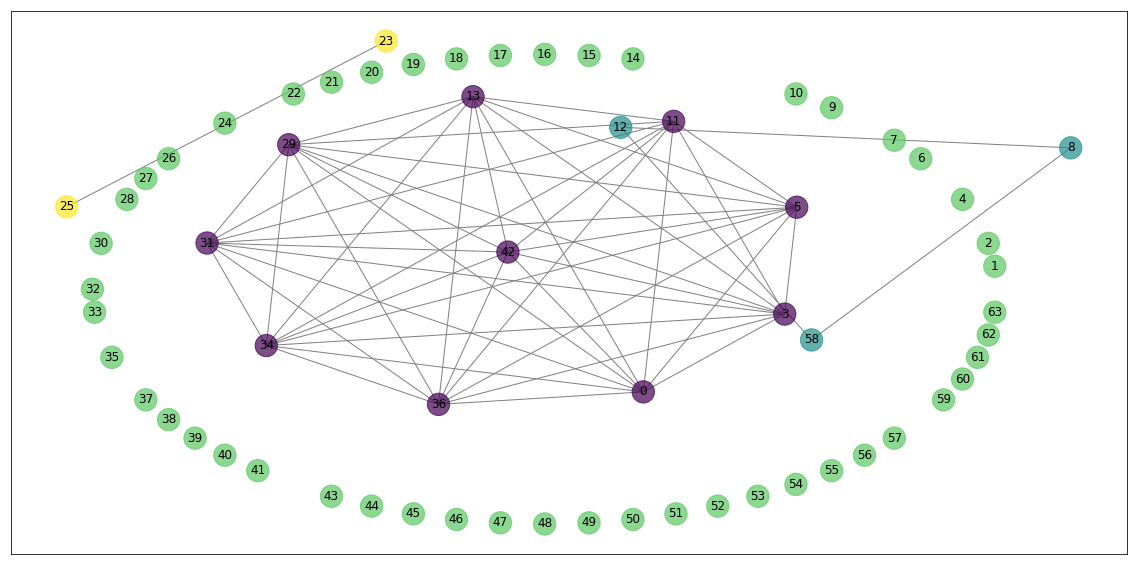

In [69]:
draw_clustered_network(clusters)

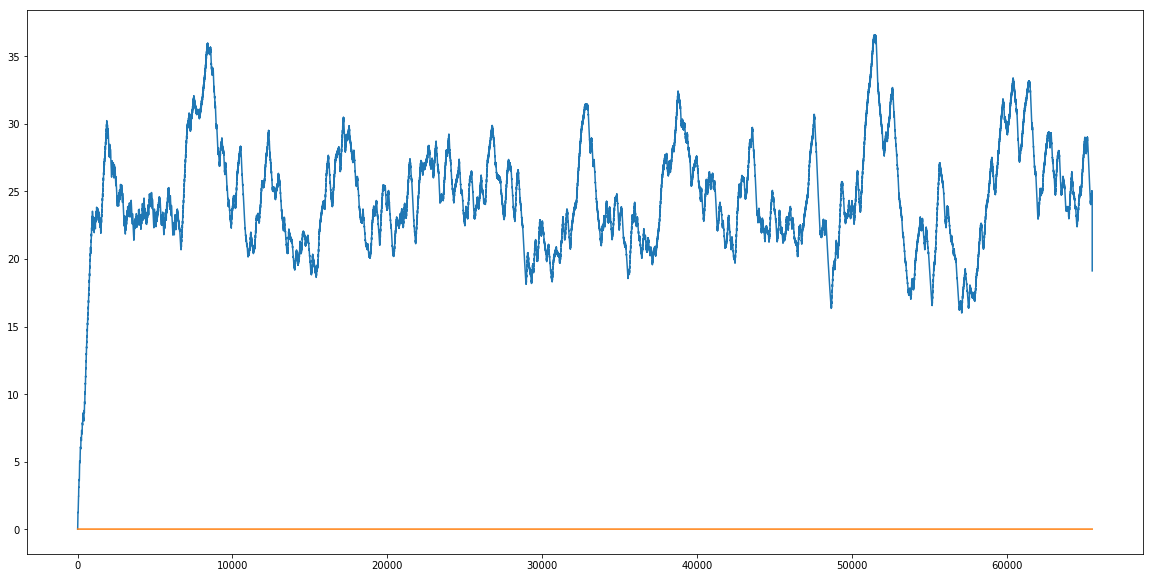

In [31]:
plt.figure(figsize=(20, 10))
for c in clusters[1]:
    plt.plot(W[4, c])
plt.show()

-0.00203778567502
0.00274922358129
87
87


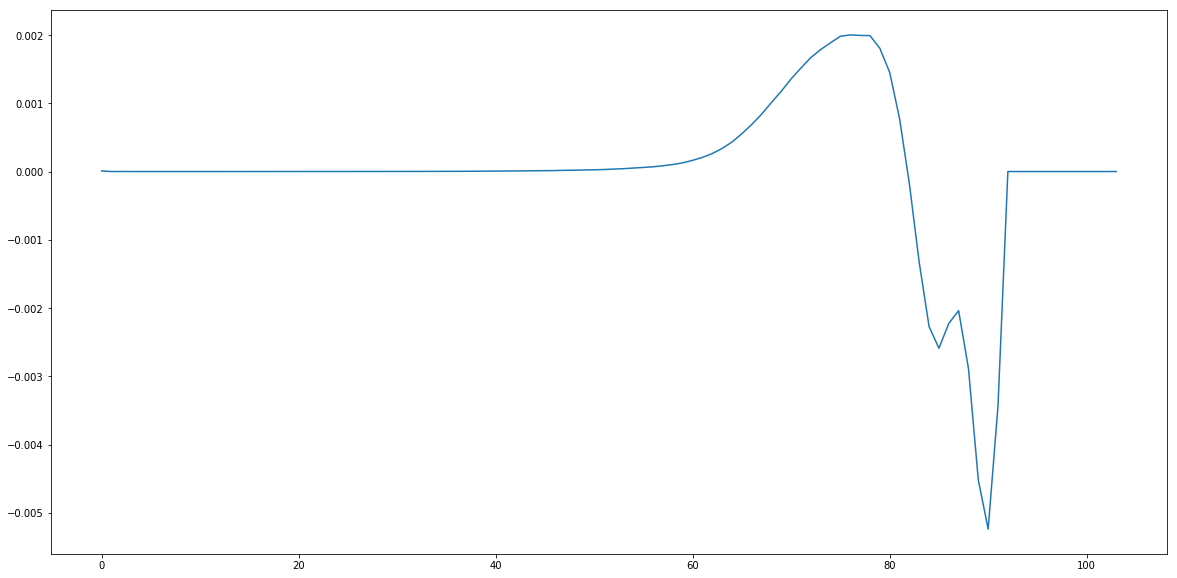

In [48]:
#dist1 = CWTDistribution(W[8, 12, 6000:10096], Ricker())
dist1 = CWTDistribution(W[25, 23, 6000:10096], Ricker())
dist2 = CWTDistribution(W[5, 13, 6000:10096], Ricker()) 
plt.figure(figsize=(20, 10))
plt.plot(dist1.value - dist2.value)
#plt.plot(dist1.value)
#plt.plot(dist2.value)
print(dist1.value[dist1.moda] - dist2.value[dist2.moda])
print(dist1.jensen(dist2))
print(dist1.moda)
print(dist2.moda)
plt.show()

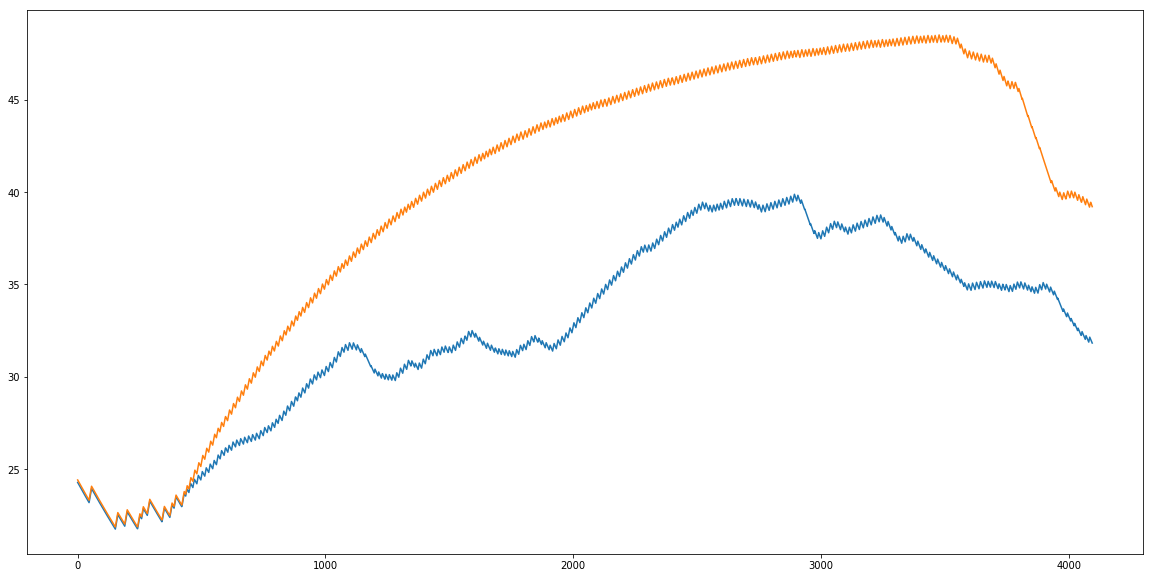

In [137]:
plt.figure(figsize=(20, 10))
plt.plot(W[63, 39, 6000:10096])
plt.plot(signal1)
plt.show()

In [36]:
g = nx.complete_graph(N)        
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos,
                       node_color = values, node_size = 500)
plt.xticks([])
plt.yticks([])
plt.show()

NameError: name 'values' is not defined